In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from signal_tl import Signal

plt.rcParams['figure.figsize'] = [10, 4]

In [2]:
# Hyperparameters

time_step = 0.1
duration = 10
n_cp = 10  # should be above 3 (due to differential operation)

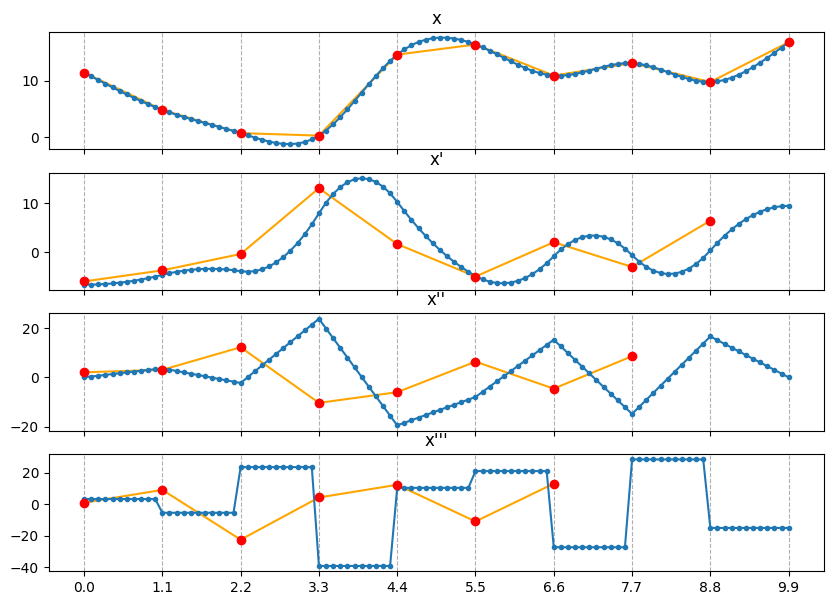

In [3]:
def pick_n_dividing_points(target: np.ndarray, n: int, force_include_end = False) -> np.ndarray:
    if force_include_end:
        q = len(target) / (n - 1)
        idx = [*[int(np.floor(i * q)) for i in range(n-1)], -1]
    else:
        q = len(target) / n
        idx = [int(np.floor(i * q)) for i in range(n)]
    return target[idx]


def generate_diff_signals(
    symbol: str, control_points, valuation, times, max_deriv_order=0):
    if max_deriv_order < 0:
        raise ValueError("max_deriv_order=#{max_deriv_order} given."
                         "Derivative order shoud be a non-negative integer.")
    elif max_deriv_order > 3:
        raise ValueError("max_deriv_order=#{max_deriv_order} given."
                         "Currently only n<=3 order of derivatives are supported.")

    spline = scipy.interpolate.make_interp_spline(control_points, valuation, bc_type="natural")
    def nth_deriv(n):
        if n<= 0:
            values = spline(times)
        else:
            values = spline(times, n)
        return Signal(values, times)
    return {
        (symbol + "'" * i): nth_deriv(i) 
        for i in range(max_deriv_order + 1)
    }


time_series = np.arange(0, duration, time_step)
control_points = pick_n_dividing_points(time_series, n_cp, force_include_end=True)
search_dim = len(control_points) 

sample =  18 * np.random.default_rng(0).random(search_dim)
trace0 = generate_diff_signals("x", control_points, sample, time_series, 3)

def finite_diff_forward(times, values, order=1):
    if order < 0:
        raise ValueError("order=#{max_deriv_order} given."
                         "Derivative order shoud be a non-negative integer.")
    elif order == 0:
        return times, values

    dt = np.diff(times)
    if order == 1:
        dtn = dt
    else:
        dtn = dt[:-(order - 1)] * dt[order - 1:]
    df = np.diff(values, order) / dtn
    return times[:-order], df

fig, ax = plt.subplots(4, sharex=True, figsize=[10,7])
for n in range(0, 4):
    signal_name = "x" + "'" * n
    signal = trace0[signal_name]
    fd_times, fd_values = finite_diff_forward(control_points, sample, n)
    ax[n].plot(fd_times, fd_values, '-', color='orange')
    ax[n].plot(signal.times, signal.values, '.-')
    ax[n].plot(fd_times, fd_values, 'o', color='red')
    ax[n].set_xticks(control_points)
    ax[n].grid(axis="x", linestyle="--")
    ax[n].set_title(signal_name)